In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

from scipy.integrate import cumulative_trapezoid

import warnings
warnings.filterwarnings("ignore")

In [3]:
huwaei=pd.read_csv('training_100.csv')
huwaei['timestamp']=pd.to_datetime(huwaei['timestamp'])

print(f"This dataset has {len(huwaei)} values")

huwaei.head(10)

This dataset has 20159 values


,timestamp,kpi_value,request_count,anomaly_label
0,2020-08-14 02:00:00+02:00,0.998755,24908,0
1,2020-08-14 02:01:00+02:00,0.997683,25029,0
2,2020-08-14 02:02:00+02:00,0.998341,24115,0
3,2020-08-14 02:03:00+02:00,0.998211,24031,0
4,2020-08-14 02:04:00+02:00,0.998403,23790,0
5,2020-08-14 02:05:00+02:00,0.998315,23740,0
6,2020-08-14 02:06:00+02:00,0.998481,23705,0
7,2020-08-14 02:07:00+02:00,0.998712,23292,0
8,2020-08-14 02:08:00+02:00,0.999055,23288,0
9,2020-08-14 02:09:00+02:00,0.998633,23412,0


In [8]:
#huwaei.iloc[0]
#huwaei.iloc[100]
#huwaei.iloc[200]

Text(0.5, 1.0, 'Huwaei Dataset')

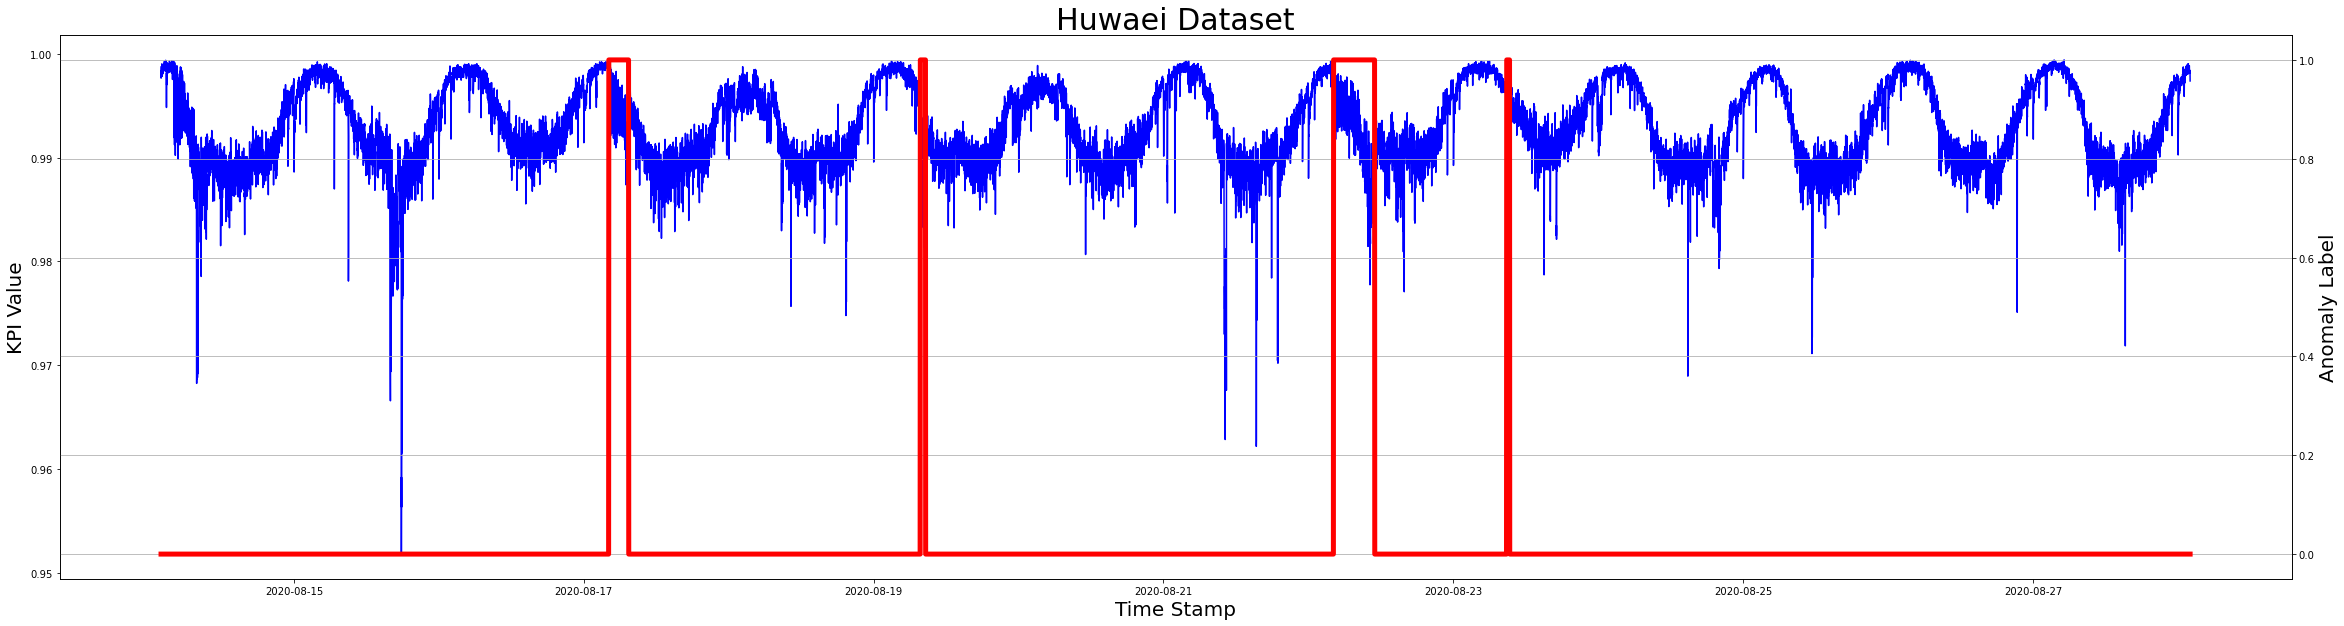

In [3]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

In [4]:
kpi=huwaei['kpi_value']
timestamp=huwaei['timestamp']

In [5]:
first_diff = kpi.diff()[1:]

In [6]:
first_diff

1       -0.001073
2        0.000659
3       -0.000131
4        0.000192
5       -0.000088
           ...   
20154   -0.000239
20155    0.000191
20156    0.000024
20157    0.000064
20158   -0.001021
Name: kpi_value, Length: 20158, dtype: float64

In [7]:
new_time=timestamp[1:]

Text(0.5, 1.0, 'Huwaei Dataset')

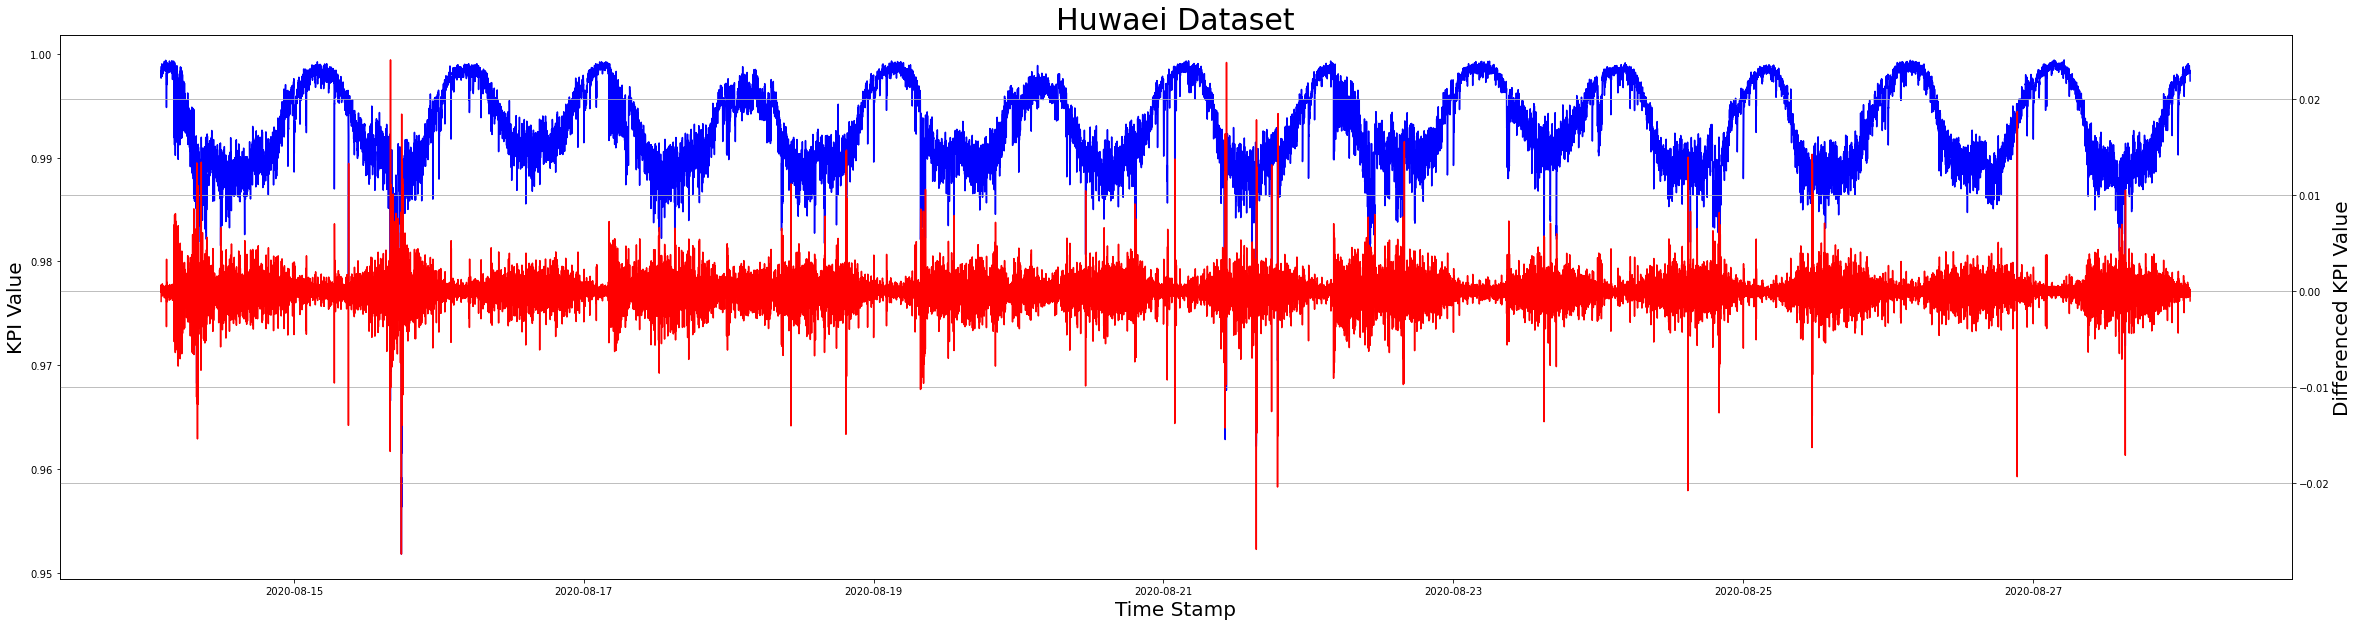

In [8]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, kpi, color='blue')
ax2a.plot(new_time, first_diff, color='red')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('KPI Value', fontsize=20)
ax2a.set_ylabel('Differenced KPI Value', fontsize=20)

plt.grid()

plt.title('Huwaei Dataset', fontsize=30)

In [9]:
used_dataset = kpi
used_dataset

0        0.998755
1        0.997683
2        0.998341
3        0.998211
4        0.998403
           ...   
20154    0.998149
20155    0.998340
20156    0.998364
20157    0.998428
20158    0.997407
Name: kpi_value, Length: 20159, dtype: float64

<BarContainer object of 20 artists>

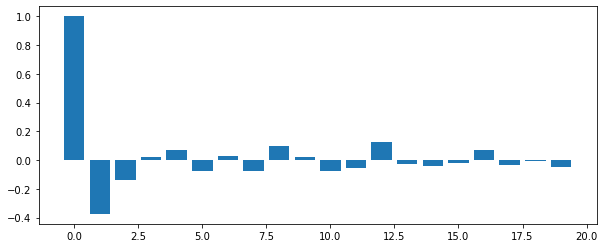

In [10]:
plt.figure(figsize=(10,4))
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

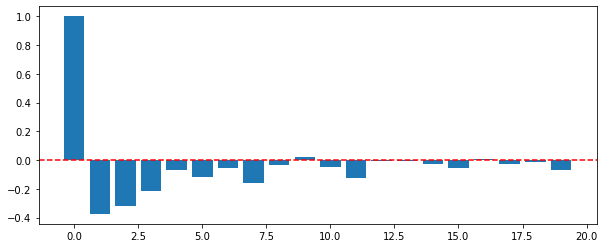

In [11]:
plt.figure(figsize=(10,4))
pacf_vals = pacf(first_diff)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.axhline(y=0, color='red', linestyle='--')

FROM THE ACF GRAPH:
###################
p is 12 since it has no significant positive spikes
d is 1 from the first difference
q is 1 significant negative spikes
  
FROM THE PACF GRAPH:
####################
P is 0 since it has a significant positive spike
D is 1 from the first seasonal difference
Q is 1 significant negative seasonal spikes
m is 10 from the seasonal analysis


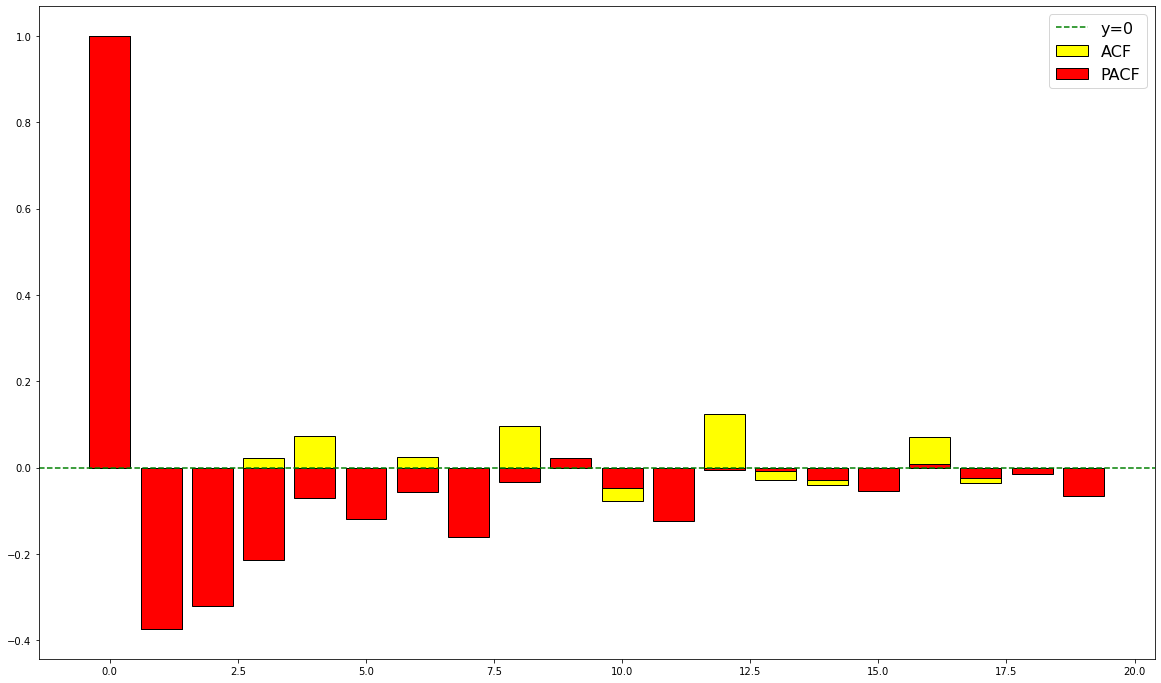

In [12]:
plt.figure(figsize=(20,12))
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags], color='yellow', edgecolor='black')
plt.bar(range(num_lags), pacf_vals[:num_lags], color='red' , edgecolor='black')
plt.axhline(y=0, color='green', linestyle='--')

plt.legend(('y=0', 'ACF', 'PACF'), fontsize=16)

print("FROM THE ACF GRAPH:")
print("###################")
print("p is 12 since it has no significant positive spikes")
print("d is 1 from the first difference")
print("q is 1 significant negative spikes")
print("  ")
print("FROM THE PACF GRAPH:")
print("####################")
print("P is 0 since it has a significant positive spike")
print("D is 1 from the first seasonal difference")
print("Q is 1 significant negative seasonal spikes")
print("m is 10 from the seasonal analysis")

In [13]:
# plt.figure(figsize=(20,10))
# plot_pacf(used_dataset)
# plt.show()

In [14]:
percent_test=80
percent_test=percent_test/100

time=timestamp 
time_point=timestamp[round(len(used_dataset)*percent_test)]
time_point

train, test = used_dataset.loc[timestamp <= time_point], used_dataset.loc[timestamp > time_point]

print(f"Number of Training Data: {train.shape[0]}")
print(f"Number of Testing Data: {test.shape[0]}")

Number of Training Data: 16128
Number of Testing Data: 4031


In [ ]:
order = (1,1,1)
seasonal_order = (1, 0, 1, 1439)#1439, 10

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

model_fit = model.fit()
print(model_fit.summary())

In [ ]:
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(predictions)
#plt.axhline(0, linestyle='--', color='k')
plt.title('Prediction from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
#plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
plt.figure(figsize=(20,4))

plt.plot(kpi)
plt.plot(predictions)
#plt.plot(residuals)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test)),4))

In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

# Using the Rolling Forecast Origin

In [ ]:
rolling_predictions = test.copy()

In [ ]:
train_end=len(train)
train_end

In [ ]:
# for train_end in test.index:
#     train = used_dataset[:train_end-0]
#     model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
#     model_fit = model.fit()
    
#     pred = model_fit.forecast()
#     rolling_predictions[train_end] = pred

In [ ]:
rolling_residuals = test - rolling_predictions

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
plt.plot(used_dataset)

In [ ]:
plt.plot(data)

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(data)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('y', fontsize=16)

In [ ]:
plt.figure(figsize=(40,12))

plt.plot(data, color='black', linewidth=3.0)
plt.plot(predictions, color='blue', linewidth=3.0, linestyle='--')
plt.plot(rolling_predictions, color='red', linewidth=3.0, linestyle='dashdot')

plt.axvline(x=20*0, color='green', linestyle='--')
plt.axvline(x=20*1, color='green', linestyle='--')
plt.axvline(x=20*2, color='green', linestyle='--')
plt.axvline(x=20*3, color='green', linestyle='--')
plt.axvline(x=20*4, color='green', linestyle='--')
plt.axvline(x=20*5, color='green', linestyle='--')
plt.axvline(x=20*6, color='green', linestyle='--')
plt.axvline(x=20*7, color='green', linestyle='--')
plt.axvline(x=20*8, color='green', linestyle='--')
plt.axvline(x=20*9, color='green', linestyle='--')
plt.axvline(x=20*10, color='green', linestyle='--')

plt.title('Seasonal Trend With Different Prediction Method', fontsize=50)
plt.xlabel('Time', fontsize=50)
plt.ylabel('Aplitude', fontsize=50)
plt.grid(True, which='both')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(('Data', 'Predictions From SARIMA', 'Rolling Predictions'), fontsize=16)

plt.savefig('Seasonal Trend With Different Prediction Method')